# Downstream analysis on Visium HD data of mouse small intestine

In [15]:
# Importing packages
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.cluster import KMeans
rcParams['pdf.fonttype'] = 42
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Setting your work dictionary
os.chdir("/home/project/metachat_packages/")

In [3]:
import sys
sys.path.append("/home/project/metachat_packages/MetaChat-main/")
import metachat_new as mc

## Import MetaChat results 

In [4]:
adata = sc.read('datasets/mouse_small_intestine/metachat_result.h5ad')
adata.obs['Cluster'] = adata.obs['Cluster'].astype(str).astype('category')

In [5]:
adata

AnnData object with n_obs × n_vars = 3264 × 19488
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region', 'Cluster', 'barrier_shapes', 'barrier', 'LRC_Blood_avg_markers', 'LRC_Blood_marker_unfiltered', 'LRC_Blood_marker_filtered', 'visualize_LRC_marker', 'LRC_Blood_closepoint_cluster1'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Cluster_colors', 'LRC_Blood_marker_filtered_colors', 'LRC_Blood_marker_unfiltered_colors', 'MetaChat-MetaChatDB-info', 'barrier_shapes', 'df_metasen_filtered', 'log1p', 'non_visible_pair', 'spatial', 'spatialdata_attrs', 'visualize_LRC_marker_colors'
    obsm: 'MetaChat-MetaChatDB-sum-receiver', 'MetaChat-MetaChatDB-sum-sender', 'spatial'
    obsp: 'LRC_shortest_Blood_dist80_cluster1', 'MetaChat-MetaChatDB-receiver-HMDB0000011-Hcar2', 'MetaChat-MetaChatDB-receiver-HMDB0000011-Slc16a7', 'MetaChat-MetaChatDB-receiver-HMDB0000011-Slc5a8', 'MetaChat-MetaChatDB-receiver-HMDB0000012-Slc29a2', 'MetaChat-MetaChatDB-receiver-HMDB0000014-Slc

## Compute group-level MCC of all pairs

To cluster MCC flow among all pairs, we need to compute group-level MCCs across all metabolite–sensor pairs.

In [6]:
# extract all_ms_pairs
df_metasen_filtered = adata.uns['df_metasen_filtered']
all_ms_pairs = (df_metasen_filtered['HMDB.ID'] + '-' + df_metasen_filtered['Sensor.Gene']).tolist()

In [7]:
mc.tl.communication_flow(adata = adata,
                         database_name = 'MetaChatDB',
                         sum_ms_pairs = all_ms_pairs,
                         k = 10)

Similarly, since the small intestine tissue is rolled, we used Napari to manually select a representative subregion for MCC flow clustering.
Here, we directly import the preprocessed results of this selected subregion for further analysis.

In [7]:
adata = sc.read_h5ad('datasets/mouse_small_intestine/metachat_result_flow_subset.h5ad')
adata_sub = adata[adata.obs['subset_direction_shapes'] == True]

In [8]:
adata

AnnData object with n_obs × n_vars = 3264 × 19488
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region', 'Cluster', 'barrier_shapes', 'barrier', 'LRC_Blood_avg_markers', 'LRC_Blood_marker_unfiltered', 'LRC_Blood_marker_filtered', 'visualize_LRC_marker', 'LRC_Blood_closepoint_cluster1', 'subset_direction_shapes'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Cluster_colors', 'LRC_Blood_marker_filtered_colors', 'LRC_Blood_marker_unfiltered_colors', 'MetaChat-MetaChatDB-info', 'barrier_shapes', 'df_metasen_filtered', 'log1p', 'non_visible_pair', 'spatial', 'spatialdata_attrs', 'subset_direction_shapes', 'visualize_LRC_marker_colors'
    obsm: 'MetaChat-MetaChatDB-sum-receiver', 'MetaChat-MetaChatDB-sum-sender', 'MetaChat-vf-MetaChatDB-receiver-HMDB0000011-Hcar2', 'MetaChat-vf-MetaChatDB-receiver-HMDB0000011-Slc16a7', 'MetaChat-vf-MetaChatDB-receiver-HMDB0000011-Slc5a8', 'MetaChat-vf-MetaChatDB-receiver-HMDB0000012-Slc29a2', 'MetaChat-vf-MetaChatDB-receiver-HMDB

As an example:

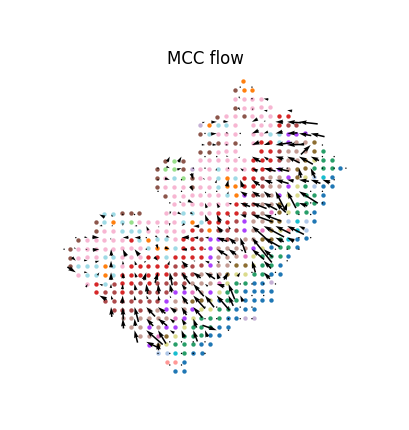

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
pl = mc.pl.plot_communication_flow(
    adata = adata_sub, 
    database_name = 'MetaChatDB',
    ms_pair_name = 'HMDB0000094-Slc25a1',
    plot_method = 'grid',
    background = 'group',
    group_name = 'Cluster',
    summary = 'receiver',
    ndsize = 10,
    largest_arrow = 0.05,
    normalize_v_quantile = 0.995,
    grid_density = 0.5,
    title = 'MCC flow',
    ax = ax)

In this step, we compute the directional histograms of MCC (metabolite–sensor) flow vectors for all selected pairs. For each pair, the communication flow field is first sampled on a regular spatial grid (controlled by grid_density), and grid points with zero vectors across all pairs are excluded.
Then, the angle of each nonzero vector is calculated using atan2(Vy, Vx) and binned into 18 angular intervals, while an additional bin records the fraction of zero vectors.
The resulting 19-dimensional histogram represents the directional pattern of each M–S pair, which can be used for downstream analyses such as flow clustering or pathway-level comparison.

In [10]:
df_hist, coords_ref = mc.tl.compute_direction_histogram_per_pair(
    adata = adata_sub,
    database_name = "MetaChatDB",
    all_ms_pairs = all_ms_pairs,
    summary = "receiver",
    grid_density = 0.5,
    n_bins = 18,
    eps = 1e-4
)

Filtered out 373 all-zero grids, kept 302.
Computed 802 flows × 19 bins (after filtering).


In [11]:
df_filt = df_hist[df_hist["dir_bin_zero"] <= 0.9].copy()
print(f"Kept {len(df_filt)} / {len(df_hist)} pairs (zero ≤ 0.9).")

Kept 333 / 802 pairs (zero ≤ 0.9).


In [12]:
df_filt

,dir_bin_0,dir_bin_1,dir_bin_2,dir_bin_3,dir_bin_4,dir_bin_5,dir_bin_6,dir_bin_7,dir_bin_8,dir_bin_9,dir_bin_10,dir_bin_11,dir_bin_12,dir_bin_13,dir_bin_14,dir_bin_15,dir_bin_16,dir_bin_17,dir_bin_zero
HMDB0000067-Abca1,0.106061,0.106061,0.060606,0.000000,0.000000,0.000000,0.060606,0.000000,0.045455,0.090909,0.106061,0.090909,0.075758,0.196970,0.015152,0.015152,0.015152,0.015152,0.781457
HMDB0000125-Abcb6,0.024390,0.065041,0.040650,0.000000,0.024390,0.032520,0.032520,0.048780,0.089431,0.056911,0.073171,0.089431,0.138211,0.154472,0.040650,0.032520,0.048780,0.008130,0.592715
HMDB0000125-Abcc1,0.000000,0.140000,0.100000,0.080000,0.000000,0.040000,0.060000,0.040000,0.080000,0.060000,0.000000,0.140000,0.120000,0.140000,0.000000,0.000000,0.000000,0.000000,0.834437
HMDB0001032-Abcc3,0.072848,0.099338,0.033113,0.066225,0.059603,0.033113,0.046358,0.052980,0.066225,0.092715,0.046358,0.039735,0.046358,0.079470,0.112583,0.019868,0.013245,0.019868,0.500000
HMDB0000626-Abcc3,0.172185,0.079470,0.172185,0.158940,0.231788,0.019868,0.000000,0.013245,0.013245,0.033113,0.000000,0.006623,0.046358,0.006623,0.000000,0.006623,0.013245,0.026490,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMDB0000191-Ucp2,0.071685,0.154122,0.172043,0.096774,0.028674,0.017921,0.025090,0.003584,0.025090,0.068100,0.057348,0.089606,0.050179,0.046595,0.039427,0.014337,0.014337,0.025090,0.076159
HMDB0000156-Ucp2,0.064516,0.157706,0.157706,0.086022,0.039427,0.014337,0.010753,0.010753,0.050179,0.064516,0.068100,0.100358,0.046595,0.060932,0.007168,0.025090,0.017921,0.017921,0.076159
HMDB0003550-Vdr,0.127753,0.171806,0.171806,0.162996,0.118943,0.026432,0.013216,0.004405,0.008811,0.022026,0.013216,0.035242,0.048458,0.017621,0.013216,0.008811,0.017621,0.017621,0.248344
HMDB0000761-Vdr,0.074890,0.158590,0.105727,0.127753,0.092511,0.035242,0.004405,0.004405,0.030837,0.030837,0.057269,0.070485,0.070485,0.035242,0.030837,0.008811,0.035242,0.026432,0.248344


The last column represents the proportion of zero vectors. Here, we cluster the directional histograms of the first 18 bins.

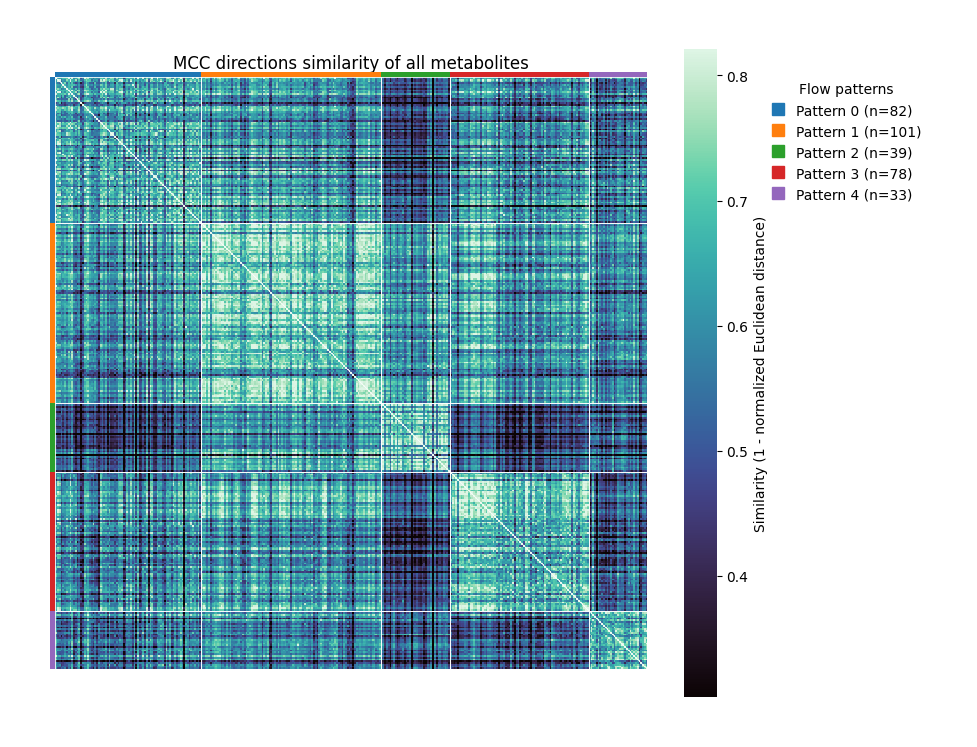

In [18]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init=50)
X = df_filt[[f"dir_bin_{i}" for i in range(18)]]
labels = kmeans.fit_predict(X)

mc.pl.plot_direction_similarity(
    df_direction=df_filt[[f"dir_bin_{i}" for i in range(18)]],
    cluster_labels=labels,
    cmap="mako",
    title="MCC directions similarity of all metabolites"
)